In [1]:
import camb
import numpy as np
import matplotlib.pyplot as plt

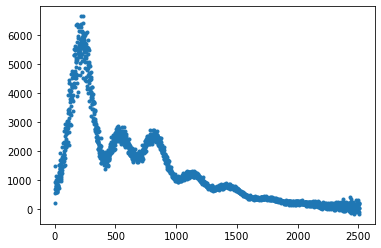

In [2]:
f = np.loadtxt('./COM_PowerSpect_CMB-TT-full_R3.01.txt')
multipole=f[:,0]
Sky_Variance=f[:,1]
low=f[:,2]
high=f[:,3]
plt.plot(multipole, Sky_Variance, '.')

chisq is  15267.937968222595  for parameters [6.e+01 2.e-02 1.e-01 5.e-02 2.e-09 1.e+00]  and  2501  degrees of freedom.
chisq is  3272.2033778089576  for parameters [6.9e+01 2.2e-02 1.2e-01 6.0e-02 2.1e-09 9.5e-01]  and  2501  degrees of freedom.


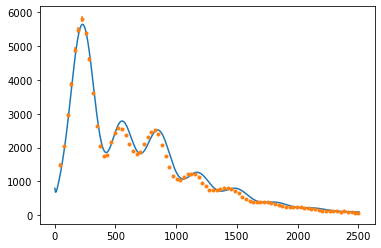

In [3]:
def get_spectrum(pars,lmax=3000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt[2:]

plt.ion()

pars=np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])
pars2 = np.asarray([69, 0.022, 0.12, 0.06, 2.1e-9, 0.95])

planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3])

model=get_spectrum(pars)
model2=get_spectrum(pars2)
model=model[:len(spec)]
model2=model2[:len(spec)]
resid=spec-model
resid2=spec-model2
chisq=np.sum((resid/errs)**2)
chisq2=np.sum((resid2/errs)**2)
print("chisq is ",chisq," for parameters",pars, " and ",len(resid)-len(pars)," degrees of freedom.")
print("chisq is ",chisq2," for parameters",pars2, " and ",len(resid2)-len(pars2)," degrees of freedom.")
#read in a binned version of the Planck PS for plotting purposes
planck_binned=np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt',skiprows=1)
errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3]);
plt.clf()
plt.plot(ell,model)
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
plt.show()



In [5]:
x = Deriv(get_spectrum, [60,0.02,0.1,0.05,2.00e-9,1.0])
np.mean(x[:,0])

NameError: name 'Deriv' is not defined

In [9]:
def ndiff(fun, args, pos):
    x = args[pos]
    dx = 1e-5 * x
    args[pos] = x+dx
    fx1 = fun(args)
    args[pos] = x-dx
    fx2 = fun(args)
    deriv = (fx1 - fx2)/(2*dx)
    return deriv

def Deriv(fun, args):
    y = fun(args)
    derivs = np.zeros([len(y), len(args)])
    for i in range(len(args)):
        derivs[:, i] = ndiff(get_spectrum, args, i)
    return derivs

def update_lamda(lamda, success):
    if success: 
        lamda = lamda/1.5
        if lamda<0.5:
            lamda=0
    else : 
        if lamda==0:
            lamda=1
        else : 
            lamda=lamda*1.5**2
    return lamda
            
def fit_LM(fun, args, y, error, niter=50, chitol=0.01):
    lamda = 1
    model = fun(args)
    model = model[:len(y)]
    r = y-model
    chisq_old = np.sum((r/error)**2)
    print('Initial chisq value is ', chisq_old)
    for i in range(niter):
        #Get trial step
        deriv = Deriv(fun, args)
        model = model[:len(y)]
        deriv = deriv[:len(y)]
        r = y-model
        lhs = deriv.T@deriv
        lhs = lhs + lamda*np.diag(np.diag(lhs))
        rhs = deriv.T@r
        dm = np.linalg.inv(lhs)@rhs
        args_trial = args+dm
        #Re-calculate the model to get chi-squared
        model = fun(args_trial)
        model = model[:len(y)]
        r = y-model
        chisq_new = np.sum((r/error)**2)
        if chisq_new<chisq_old:
            lamda = update_lamda(lamda, True)
            args = args_trial
            print('accepting step with new chisq ',chisq_new, 'and old chisq ',chisq_old)
            chisq_old = chisq_new
        elif np.abs(chisq_new-chisq_old)<chitol:
            break
        else :
            lamda = update_lamda(lamda, False)
            print('rejecting step with new chisq ',chisq_new, 'and old chisq ',chisq_old)
        print('On iteration', i, 'chisq is ', chisq_new, 'with step ', dm, 'and lamda ', lamda)
    last_deriv = Deriv(fun, args)
    last_lhs = last_deriv.T@last_deriv
    Cov = np.linalg.inv(last_lhs)
    errors = np.sqrt(np.diag(Cov))
    return args, errors, last_lhs

In [7]:
params = np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])
Deriv(get_spectrum, params)

array([[ 1.32833788e+01, -3.08290471e+03, -3.28167193e+03,
         2.31081451e+02,  3.97543903e+11, -3.90129494e+03],
       [ 1.02112576e+01, -2.64469733e+03, -2.49084984e+03,
         1.07630817e+02,  3.82017467e+11, -3.57873708e+03],
       [ 7.99698508e+00, -2.24395061e+03, -1.93177909e+03,
        -6.89732844e+01,  3.65907713e+11, -3.28855816e+03],
       ...,
       [-4.39487344e-01,  1.51051865e+03, -1.25562515e+02,
        -5.49800147e+01,  1.51970828e+10,  4.07141690e+01],
       [-4.36306904e-01,  1.50794092e+03, -1.24448470e+02,
        -5.48931030e+01,  1.51665966e+10,  4.06698644e+01],
       [-4.33215291e-01,  1.50544622e+03, -1.23373904e+02,
        -5.48067216e+01,  1.51361933e+10,  4.06259987e+01]])

In [10]:
params = np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])
start_y = planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3])
Bestfit_args, Bestfit_err, Cur = fit_LM(get_spectrum, params, start_y, errs)
Cur = np.linalg.inv(Cur)

Initial chisq value is  15267.937968222595
accepting step with new chisq  5219.453288697082 and old chisq  15267.937968222595
On iteration 0 chisq is  5219.453288697082 with step  [ 4.96599818e+00  1.55679536e-04  3.07418180e-03  2.14942646e-03
 -8.13450976e-12 -1.71315665e-02] and lamda  0.6666666666666666
accepting step with new chisq  3212.1743111837213 and old chisq  5219.453288697082
On iteration 1 chisq is  3212.1743111837213 with step  [ 3.38069375e+00  5.32098335e-04  1.92043872e-03 -4.26811659e-04
  1.71921232e-12 -9.90353287e-03] and lamda  0
rejecting step with new chisq  6500.447764976598 and old chisq  3212.1743111837213
On iteration 2 chisq is  6500.447764976598 with step  [-1.58393169e+00  1.47404616e-03  1.41363699e-02 -9.07407714e-02
 -2.72048015e-10 -1.35381297e-02] and lamda  1
rejecting step with new chisq  5013.7774590440595 and old chisq  3212.1743111837213
On iteration 3 chisq is  5013.7774590440595 with step  [ 1.58902813e-01  2.24659632e-04 -2.57224702e-03 -1.0

rejecting step with new chisq  2711.8682023712045 and old chisq  2655.3836126305296
On iteration 32 chisq is  2711.8682023712045 with step  [-2.66584331e-01  2.51710834e-04 -8.47208923e-04 -2.28790205e-03
  9.14613725e-12 -3.79666438e-03] and lamda  11.390625
rejecting step with new chisq  2678.453908070297 and old chisq  2655.3836126305296
On iteration 33 chisq is  2678.453908070297 with step  [ 8.89573681e-02 -5.98762239e-05  2.54487090e-04  5.34605058e-04
 -2.15307491e-12  1.15482052e-03] and lamda  25.62890625
accepting step with new chisq  2653.504863405016 and old chisq  2655.3836126305296
On iteration 34 chisq is  2653.504863405016 with step  [-9.50827788e-03  1.21417878e-05 -2.26581196e-05 -8.60156414e-05
  3.40066616e-13 -9.61980247e-05] and lamda  17.0859375
accepting step with new chisq  2653.043490556693 and old chisq  2653.504863405016
On iteration 35 chisq is  2653.043490556693 with step  [ 5.76607916e-03  3.06674013e-06  1.94580807e-05 -3.13802013e-06
  5.56902475e-15  9

In [13]:
line = ['The best-fit parameters are: ','H0: '+str(Bestfit_args[0])+' +/- '+str(Bestfit_err[0]),
        'ombh2: '+str(Bestfit_args[1])+' +/- '+str(Bestfit_err[1]), 
        'omch2: '+str(Bestfit_args[2])+' +/- '+str(Bestfit_err[2]),
        'tau: '+str(Bestfit_args[3])+' +/- '+str(Bestfit_err[3]),
        'As: '+str(Bestfit_args[4])+' +/- '+str(Bestfit_err[4]),
        'ns: '+str(Bestfit_args[5])+' +/- '+str(Bestfit_err[5])]
L = open('./planck_fit_params.txt', 'w')
for elem in line: 
    L.write(elem+'\n')
L.close()

param chain is:  [[6.00000000e+01 2.00000000e-02 1.00000000e-01 5.00000000e-02
  2.00000000e-09 1.00000000e+00]
 [6.00000000e+01 2.00000000e-02 1.00000000e-01 5.00000000e-02
  2.00000000e-09 1.00000000e+00]
 [6.00000000e+01 2.00000000e-02 1.00000000e-01 5.00000000e-02
  2.00000000e-09 1.00000000e+00]
 ...
 [6.16746067e+01 1.99913243e-02 1.02019076e-01 6.89914022e-02
  1.94062638e-09 9.99535298e-01]
 [6.16987796e+01 1.99921635e-02 1.02020899e-01 6.81019790e-02
  1.94088342e-09 9.99500925e-01]
 [6.16987796e+01 1.99921635e-02 1.02020899e-01 6.81019790e-02
  1.94088342e-09 9.99500925e-01]] chi squared chain is:  [15267.93796822 15267.93796822 15267.93796822 14901.57520344
 14552.64627766 14552.64627766 14552.64627766 14552.64627766
 14552.64627766 14417.79498694 14133.81351037 13983.64535998
 13611.19240992 13611.19240992 13577.29343093 13577.29343093
 13577.29343093 13181.23658739 12755.02840357 12449.5187363
 12374.1724998  12374.1724998  12188.53487506 12188.53487506
 12082.97642162 119

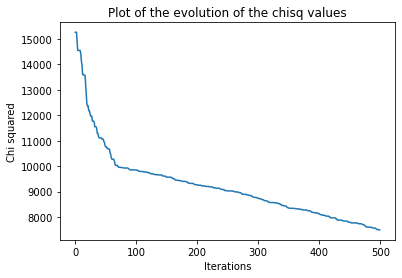

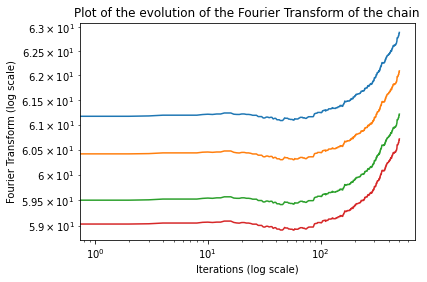

In [19]:
#Define a function to calculate the mean value of the dark energy using the H0,
# ombh2 and omch2 values generated by the MCMC function.
def Mean_Dark_Energy(H0, ombh2, omch2, H0_err, ombh2_err, omch2_err):
    #We propagate the errors through the various expressions to get a 
    #final value for the mean value of dark energy and the error on this value.
    h = H0 / 100
    h_err = H0_err / 10
    omb = ombh2 / h**2
    omb_err = (omb*h_err)/(h**3)
    omc = omch2 / h**2
    omc_err = (omc*h_err)/(h**3)
    omD = 1 - omb - omc
    omD_err = np.sqrt(omb_err**2 + omc_err**2)
    return omD, omD_err

#Define a function to calculate the chi squared value for a given set of arguments and a set of data points.
#We fix the errors to the ones found in the COM_PowerSpect_CMB-TT-full_R3.01.txt file, since we won't be using
#any other data for these questions. 
def get_spectrum_chisq(args, y, errors=errs):
    model = get_spectrum(args)
    model = model[:len(y)]
    r = y - model
    chisq = np.sum((r/errors)**2)
    return chisq

#Make an MCMC sampler.
def mcmc(pars,y,fun,curv,nstep):
    #We calculate the current value of chi squared to start off the chain.
    chi_cur=fun(pars,y)
    npar=len(pars)
    
    #Initialize the chains for the parameters and chi squared values.
    chain=np.zeros([nstep,npar])
    chivec=np.zeros(nstep)
    #Using the cholesky decomposition we get a single value from the curvature matrix
    #which we can use as our step size. 
    L = np.linalg.cholesky(curv)
    curv = np.dot(L,np.random.randn(npar))
    
    for i in range(nstep):
        #Get the trial parameters that we test out.
        #We add a random value to the step size so as to not get stuck in a bad part of parameter space. 
        trial_pars=pars + 2*curv*np.random.randn(npar)
        
        #Get the chi squared values for the trial parameters.
        trial_chisq=fun(trial_pars,y)
        
        #Get the difference of the old chi squared and the trial chi squared.
        delta_chisq=trial_chisq-chi_cur
        
        #If our chi squared has decreased, we update the pars and chi_cur variables, 
        #as well as the parameter and chi squared chains. 
        if delta_chisq<0:
            pars=trial_pars
            chi_cur=trial_chisq
            chain[i,:]=pars
            chivec[i]=chi_cur
        
        #If our chi squared hasn't decreased, we don't update the pars and chi_cur variables,
        #however we update the two chains, to show that the step was unsuccesful. 
        else:
            chain[i,:]=pars
            chivec[i]=chi_cur
    return chain,chivec

#Get the parameter and chi squared chains.
chain,chisq=mcmc(pars,spec,get_spectrum_chisq,Cur,nstep=500)
print('param chain is: ',chain, 'chi squared chain is: ',chisq)

#Get the mean value of dark energy from the chains
error = np.std(chain, axis=0)
bestfit_MCMC_param = chain[len(chain)-1]
omd, omd_err = Mean_Dark_Energy(bestfit_MCMC_param[0], bestfit_MCMC_param[1], bestfit_MCMC_param[2], error[0], error[1], error[2])
print('The mean value of dark energy is ', omd, ' +/- ',omd_err)
#Write mean value of dark energy to a .txt file.

line = ['The mean value of dark energy is: ', str(omd)+' +/- '+str(omd_err)]
L = open('./Problem3.txt', 'w')
for elem in line: 
    L.write(elem+'\n')
L.close()

#To test the convergence of our chains, we plot the evolution
#of chi squared to make sure that the value converges, as well as the 
#fourier transform of the parameter chain. 

plt.plot(chisq)
plt.xlabel('Iterations')
plt.ylabel('Chi squared')
plt.title('Plot of the evolution of the chisq values')
plt.savefig('./Chisq_Values.pdf')
plt.show()

chainft = np.fft.rfft(chain)
plt.loglog(np.abs(chainft))
plt.xlabel('Iterations (log scale)')
plt.ylabel('Fourier Transform (log scale)')
plt.title('Plot of the evolution of the Fourier Transform of the chain')
plt.savefig('./Convergence.pdf')
plt.show()

#We save the output of both chains to a text file, where the first column is the chi squared value for 
#each iteration of parameters. 
npar=len(bestfit_MCMC_param)
#Create a matrix containing both chains.
line = np.zeros([len(chisq), npar+1])
line[:, 0] = chisq
line[:, 1] = chain[:, 0]
line[:, 2] = chain[:, 1]
line[:, 3] = chain[:, 2]
line[:, 4] = chain[:, 3]
line[:, 5] = chain[:, 4]
line[:, 6] = chain[:, 5]
line=np.matrix(line)
#Write the matrix to a .txt file
with open('./planck_chain.txt','w') as L:
    for elem in line:
        np.savetxt(L, elem, fmt='%.17f')
L.close()

param chain is:  [[5.99990298e+01 2.00000382e-02 1.00003892e-01 5.79662632e-02
  2.00056710e-09 1.00000765e+00]
 [5.99990298e+01 2.00000382e-02 1.00003892e-01 5.79662632e-02
  2.00056710e-09 1.00000765e+00]
 [6.00068035e+01 2.00000127e-02 1.00022545e-01 6.14783697e-02
  2.00025406e-09 9.99990067e-01]
 ...
 [5.99955677e+01 2.00010965e-02 9.99785466e-02 7.60612726e-02
  1.99662547e-09 9.99983939e-01]
 [5.99955677e+01 2.00010965e-02 9.99785466e-02 7.60612726e-02
  1.99662547e-09 9.99983939e-01]
 [5.99955677e+01 2.00010965e-02 9.99785466e-02 7.60612726e-02
  1.99662547e-09 9.99983939e-01]] chi squared chain is:  [13601.49142265 13601.49142265 12918.19078634 12918.19078634
 12918.19078634 12918.19078634 12918.19078634 12918.19078634
 12918.19078634 12918.19078634 12289.56392879 12289.56392879
 12289.56392879 12289.56392879 12289.56392879 12289.56392879
 12209.96883981 11602.39218099 11602.39218099 11602.39218099
 11602.39218099 11602.39218099 11602.39218099 11602.39218099
 11602.39218099 11

The chi squared value using an mcmc sampler with importance sampling is: 9295.6278890815
The chi squared value using an mcmc sampler with a prior is: 10922.32813109248


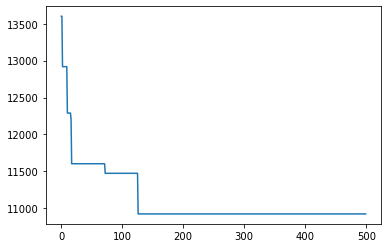

In [28]:
###Problem 4
#To impose a prior on the tau value we use the same mcmc function as in problem 3
#but we sample the value of tau at each iteration from a gaussian distribution with 
#mean 0.0540 and standard deviation 0.0074.

#We re-estimate the covariance matrix from the chains obtained in problem 3.
new_deriv = Deriv(get_spectrum, bestfit_MCMC_param)
new_lhs = new_deriv.T@new_deriv
new_Cov = np.linalg.inv(new_lhs)

def mcmc_withprior(pars,y,fun,curv,nstep):
    chi_cur=fun(pars,y)
    npar=len(pars)
    chain=np.zeros([nstep,npar])
    chivec=np.zeros(nstep)
    L = np.linalg.cholesky(curv)
    curv = np.dot(L,np.random.randn(npar))
    for i in range(nstep):
        trial_pars=pars + curv*np.random.randn(npar)
        
        #We sample the tau value for the gaussian distribution.
        trial_pars[3]=np.random.normal(0.0540, 0.0074)
        trial_chisq=fun(trial_pars,y)
        delta_chisq=trial_chisq-chi_cur
        if delta_chisq<0:
            pars=trial_pars
            chi_cur=trial_chisq
            chain[i,:]=pars
            chivec[i]=chi_cur
        else:
            chain[i,:]=pars
            chivec[i]=chi_cur
    return chain,chivec

prior_chain, prior_chisq=mcmc_withprior(pars,spec,get_spectrum_chisq,new_Cov,nstep=500)
print('param chain is: ',prior_chain, 'chi squared chain is: ',prior_chisq)
plt.plot(prior_chisq)

#Save results from mcmc_withprior to a .txt file, using the same method as problem 3
newline = np.zeros([len(prior_chisq), npar+1])
newline[:, 0] = prior_chisq
newline[:, 1] = prior_chain[:, 0]
newline[:, 2] = prior_chain[:, 1]
newline[:, 3] = prior_chain[:, 2]
newline[:, 4] = prior_chain[:, 3]
newline[:, 5] = prior_chain[:, 4]
newline[:, 6] = prior_chain[:, 5]
newline=np.matrix(newline)
#Write the matrix to a .txt file
with open('./planck_chain_tauprior.txt','w') as L:
    for elem in newline:
        np.savetxt(L, elem, fmt='%.17f')
L.close()

#Getting the mean value of each parameter from importance sampling
def prior_chisq(pars, pars_priors, par_errs):
    if pars_priors is None:
        return 0
    par_shifts=pars - pars_priors
    return np.sum((par_shifts/par_errs)**2)

expec_pars = 0*pars
expec_pars[3]=0.0540
par_errs=0*pars+1e20
par_errs[3]=0.0074

nsample=chain.shape[0]
imp_chivec = np.zeros(nsample)
for i in range(nsample):
    chisq = prior_chisq(chain[i,:],expec_pars, par_errs)
    imp_chivec[i]=chisq
imp_chivec = imp_chivec-imp_chivec.mean()
weight=np.exp(0.5*imp_chivec)

imp_pars=np.zeros(len(pars))
for i in range(len(pars)):
    imp_pars[i]=np.sum(weight*chain[:,i])/np.sum(weight)
    
#Comparing importance sampled results to results obtained from an mcmc sampler with prior

prob3_chisq = get_spectrum_chisq(imp_pars,spec)
prob4_chisq = get_spectrum_chisq(prior_chain[len(prior_chain)-1],spec)
print('The chi squared value using an mcmc sampler with importance sampling is:', prob3_chisq)
print('The chi squared value using an mcmc sampler with a prior is:', prob4_chisq)


In [29]:
line = ['The chi squared value using an mcmc sampler with importance sampling is: '+str(prob3_chisq),
        'The chi squared value using an mcmc sampler with a prior is: '+str(prob4_chisq)]
L = open('./Problem4.txt', 'w')
for elem in line: 
    L.write(elem+'\n')
L.close()

In [12]:
Cur = np.array([[ 9.39437613e-05,  1.46170140e-08, -1.69059884e-07,
         1.49786589e-06,  5.19985741e-15,  5.47825807e-07],
       [ 1.46170140e-08,  4.12509036e-12, -2.17255432e-11,
         2.97557794e-10,  1.09680186e-18,  1.01099878e-10],
       [-1.69059884e-07, -2.17255432e-11,  3.36960037e-10,
        -2.64909917e-09, -8.93389426e-18, -9.62780548e-10],
       [ 1.49786589e-06,  2.97557794e-10, -2.64909917e-09,
         7.40808977e-08,  2.85604051e-16,  1.05634556e-08],
       [ 5.19985741e-15,  1.09680186e-18, -8.93389426e-18,
         2.85604051e-16,  1.10875913e-24,  3.80842361e-17],
       [ 5.47825807e-07,  1.01099878e-10, -9.62780548e-10,
         1.05634556e-08,  3.80842361e-17,  3.62581545e-09]])